## 线性模型的正则化

### 准备数据

准备20组带有噪音的线性数据：$y=1+0.5x$

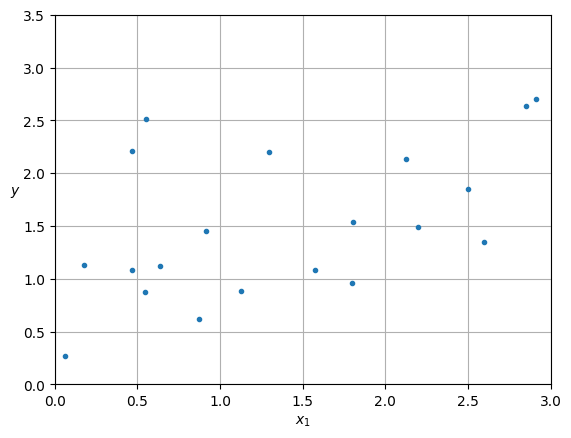

In [49]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

plt.figure()
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

### 岭回归

岭回归的损失函数是：

$$J(\theta) = MSE(\theta) + \alpha \frac{1}{2} \sum_{i=1}^{n}\theta_i^2$$

对于线性回归的岭回归，我们可以使用封闭方程去计算，也可以使用梯度下降去计算。

岭回归的封闭方程的解如下：

$$\hat{\theta}=(X^T \cdot X + \alpha A)^{-1} \cdot X^T \cdot y$$

下面使用`Scikit-Learn`提供的`Ridge`来进行封闭方程的岭回归求解。其中，`cholesky`表示使用`Cholesky`法进行矩阵分解对上面的公式进行变形。

In [50]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

下面的代码直接使用了封闭方程计算了岭回归：

In [51]:
alpha = 0.1
A = np.array([[0., 0.], [0., 1.]])
X_b = np.c_[np.ones(m), X]
theta = np.linalg.inv(X_b.T @ X_b + alpha * A) @ X_b.T @ y
print(theta)
y_pred = theta.T @ np.c_[np.ones(1), [1.5]].T
print(y_pred)

[[0.97898394]
 [0.3828496 ]]
[[1.55325833]]


同样的，我们可以用`Scikit-Learn`提供随机梯度下降算法`SGDRegressor`实现岭回归。其中，`penalty`参数指的是正则项的惩罚类型。指定`l2`表明要在损失函数上添加一项：权重向量 $ \ell^2 $ 范数平方的一半，即简单的岭回归。

In [52]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
ridge_reg.predict([[1.5]])

array([[1.55325833]])

`Scikit-Learn`的`Ridge`也提供了随机梯度下降算法实现的岭回归：

In [53]:
ridge_reg = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55326019]])

下面的代码展示了在相同线性数据上使用不同的 $\alpha$ 值的岭回归模型。左图使用了简单的岭回归模型。右图首先使用10阶的`PolynomialFeatures`对数据集进行转换，然后使用`StandardScaler`进行特征缩放，最后将岭模型应用在处理后的特征上。这就是带有岭正则项的多项式回归。

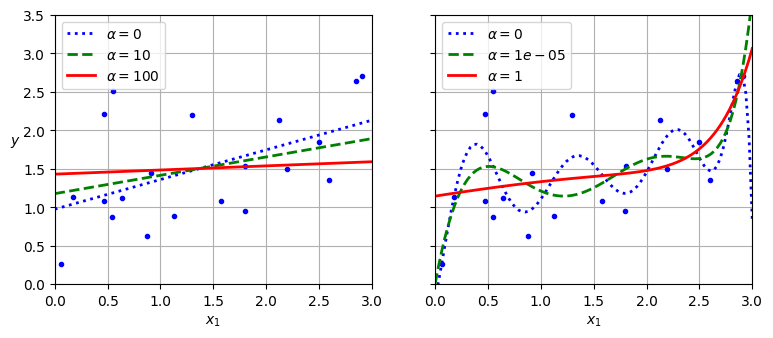

In [54]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()


### Lasso回归

利用`Scikit-Learn`的`Lasso`可以方便地实现Lasso回归：

In [55]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

同样的，我们也可以对线性回归和多项式回归添加Lasso模型，下面的代码显示了不同 $\alpha$ 下，Lasso模型的曲线。相对与Ridge回归，Lasso回归的曲线更加平滑。

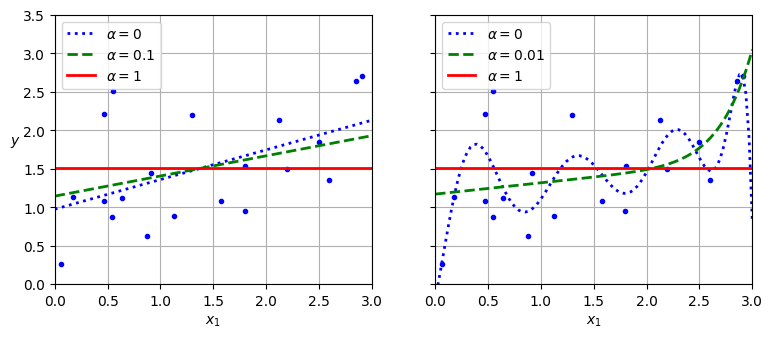

In [56]:
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

Lasso回归的一个重要特征是它倾向于完全消除最不重要的特征的权重。Lasso回归自动进行特征选择，并输出一个稀疏模型(即，具有很少的非零权重)。